In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.cross_validation as CV
from sklearn.feature_extraction import DictVectorizer as DV
from datetime import date
from sklearn import linear_model as LM

%matplotlib inline

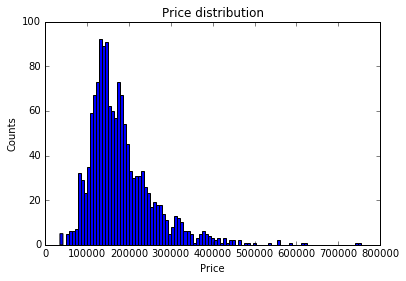

In [2]:
data = pd.read_csv('train.csv',index_col='Id')
features = data.drop('SalePrice',axis = 1)
price = data.SalePrice
plt.hist(price,bins = 100)
plt.xlabel('Price')
plt.ylabel('Counts')
plt.title('Price distribution')
plt.show()

## Search empty numeric values

In [3]:
num_columns = features.select_dtypes(exclude=['object']).columns
obj_columns = features.select_dtypes(include=['object']).columns

for feature in num_columns:
    empty = pd.isnull(features[feature]);
    count = empty[empty == True].count()
    if count>0:
        print feature, count, count*100.0/1460
        

obj_features = features[obj_columns];
obj_features.fillna('empty',inplace=True);

encoder = DV(sparse = False);
t = obj_features.T.to_dict().values();
encoded_data = encoder.fit_transform(t);

LotFrontage 259 17.7397260274
MasVnrArea 8 0.547945205479
GarageYrBlt 81 5.54794520548


D:\Anaconda\lib\site-packages\pandas\core\frame.py:2756: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


## Define functions

In [4]:
def myScore(y, y_pred):
    yLog = np.log(y);
    ind = np.isinf(yLog);
    yLog[ind == True] = 0;    
    
    y_predLog = np.log(y_pred);
    ind = np.isinf(y_predLog);
    y_predLog[ind == True] = 0;
    
    summ = np.sum(np.power(yLog-y_predLog,2))     
    return np.sqrt(summ/y.shape[0])

# replace qualitative estimation to number
def replaceQualVal(dataSet,fNameList):
    # dictionary of values
    vocab = {
        'Ex': 5, 'EX': 5, # excellent    
        'Gd': 4, 'GD': 4, # good
        'TA': 3, 'Ta': 3, # normal
        'FA': 2, 'Fa': 2, # fair
        'PO': 1, 'Po': 1  # 
        }
    
    for fName in fNameList:
        
        # replace stings to numbers
        for word in vocab:
            searchDict = {fName:[word]};
            X = dataSet.isin(searchDict);
            dataSet.loc[X[fName],fName] = vocab[word];
        
        # convert to numeric type
        dataSet[[fName]] = dataSet[[fName]].apply(pd.to_numeric);
    return dataSet;    
# end of function    

## Create folds and trees 

In [5]:
folds = CV.KFold(price.size, n_folds=5, random_state = 43);
shuffle = CV.ShuffleSplit(price.size, n_iter=3, test_size=0.33, random_state=43)

In [9]:
features = data.drop('SalePrice',axis = 1)
    
# drop heating type
features.drop('Heating',axis = 1,inplace = True);
features.drop(['MoSold', 'YrSold'],axis = 1,inplace = True);

num_features = features.select_dtypes(exclude=['object']);

# process GarageYrBlt
empty = pd.isnull(num_features['GarageYrBlt']);
ind = empty[empty == True].index;
num_features.loc[ind.values,'GarageYrBlt'] = features.loc[ind.values,'YearBuilt'];

# add new feature
num_features.loc[:,'houseAgeLog'] = np.log(date.today().year - num_features.loc[:,'YearBuilt']);
num_features.loc[:,'garageAgeLog'] = np.log(date.today().year - num_features.loc[:,'GarageYrBlt']);
num_features.loc[:,'remodeAge'] = num_features.loc[:,'YearRemodAdd'] - num_features.loc[:,'YearBuilt'];
num_features.fillna(0,inplace=True);

obj_features = features.select_dtypes(include=['object']);
obj_features.fillna('empty',inplace=True)
encoded_data = encoder.fit_transform(obj_features.T.to_dict().values());
transFeatures = np.hstack([num_features, encoded_data]);

In [10]:
X_train, X_test, y_train, y_test = CV.train_test_split(transFeatures, price, test_size=0.33,random_state=43);

[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:    2.3s finished


Score 0.145697733502


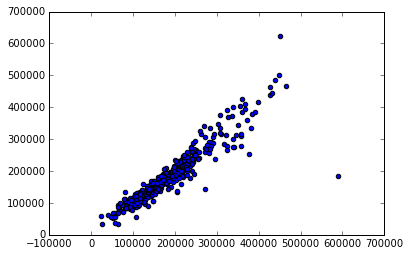

In [13]:
LCV = LM.LassoLarsCV(verbose=True, max_iter=1000, normalize=True, cv=3, n_jobs=8)
LCV.fit(X_train,y_train);
y_pr = LCV.predict(X_test);
print 'Score', myScore(y_pr,y_test);
plt.scatter(y_pr,y_test)